<a href="https://colab.research.google.com/github/Bitdribble/dlwpt-code/blob/master/colab/PyTorchCh8_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

## Data Preparation

In [2]:
data_path = '.'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


## Normalize Data

In [3]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

## Restrict data to airplanes and birds

In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

## Use CUDA if available

In [5]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


# The training loop

In [6]:
def training_loop(n_epochs, device, optimizer, model, loss_fn, train_loader, val_loader, log_epochs=0):
  hist = {
      "loss_train" : [],
      "acc_train" : [],
      "acc_val" : [],
  }

  for epoch in range(1, n_epochs + 1):
    model.train() # Set train mode for epoch
    loss_train = 0.0

    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)

      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()

    loss_train /= len(train_loader)

    # Check accuracy. This sets eval mode.
    acc_train, acc_val = validate(model, device, train_loader, val_loader)

    hist["loss_train"].append(loss_train)
    hist["acc_train"].append(acc_train)
    hist["acc_val"].append(acc_val)

    if log_epochs is not 0 and (epoch % log_epochs == 0 or epoch == n_epochs):
      print(f"{datetime.datetime.now()} Epoch {epoch}, "
            f"Loss train {loss_train:.3f} Acc train {acc_train:.3f} val {acc_val:.3f}")
      
  return hist

def validate(model, device, train_loader, val_loader):
  acc = {}
  model.eval() # Set eval mode

  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    with torch.no_grad(): 
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)

        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1) 

        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    acc[name] = correct / total
  
  return acc["train"], acc["val"]

# The network class

In [7]:
class Net(nn.Module):
  def __init__(self, n_chans1=16):
    super().__init__()

    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)           # Out: 32x32x(n_chans1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)                                            # Out: 16x16x(n_chans1)

    self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1) # Out: 16x16x(n_chans1//2)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)                                            # Out: 8x8x(n_chans1//2)

    self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)                             # Out: 32
    self.act3 = nn.Tanh()

    self.fc2 = nn.Linear(32, 2)                                             # Out: 2

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8*8*(self.n_chans1//2)) # In place of nn.Flatten()
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

# The baseline network - .85 accuracy
Build a network with 2 channels in layer 1

In [12]:
model_narrow = Net(n_chans1=2).to(device=device) # Start with n_chans2=2
optimizer = optim.SGD(model_narrow.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, 
                                         shuffle=False)

hist_narrow = training_loop(
    n_epochs = 200,
    device=device,
    optimizer = optimizer,
    model = model_narrow,

    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 03:38:39.561664 Epoch 1, Loss train 0.674 Acc train 0.735 val 0.753
2022-01-31 03:38:40.368715 Epoch 2, Loss train 0.523 Acc train 0.778 val 0.792
2022-01-31 03:38:41.174317 Epoch 3, Loss train 0.486 Acc train 0.783 val 0.799
2022-01-31 03:38:41.964915 Epoch 4, Loss train 0.472 Acc train 0.787 val 0.806
2022-01-31 03:38:42.770511 Epoch 5, Loss train 0.466 Acc train 0.789 val 0.807
2022-01-31 03:38:43.588522 Epoch 6, Loss train 0.459 Acc train 0.791 val 0.807
2022-01-31 03:38:44.386251 Epoch 7, Loss train 0.459 Acc train 0.794 val 0.810
2022-01-31 03:38:45.190877 Epoch 8, Loss train 0.454 Acc train 0.795 val 0.815
2022-01-31 03:38:45.980982 Epoch 9, Loss train 0.451 Acc train 0.797 val 0.814
2022-01-31 03:38:46.810811 Epoch 10, Loss train 0.450 Acc train 0.799 val 0.814
2022-01-31 03:38:47.632620 Epoch 11, Loss train 0.447 Acc train 0.799 val 0.820
2022-01-31 03:38:48.455998 Epoch 12, Loss train 0.447 Acc train 0.799 val 0.816
2022-01-31 03:38:49.263629 Epoch 13, Loss train 0

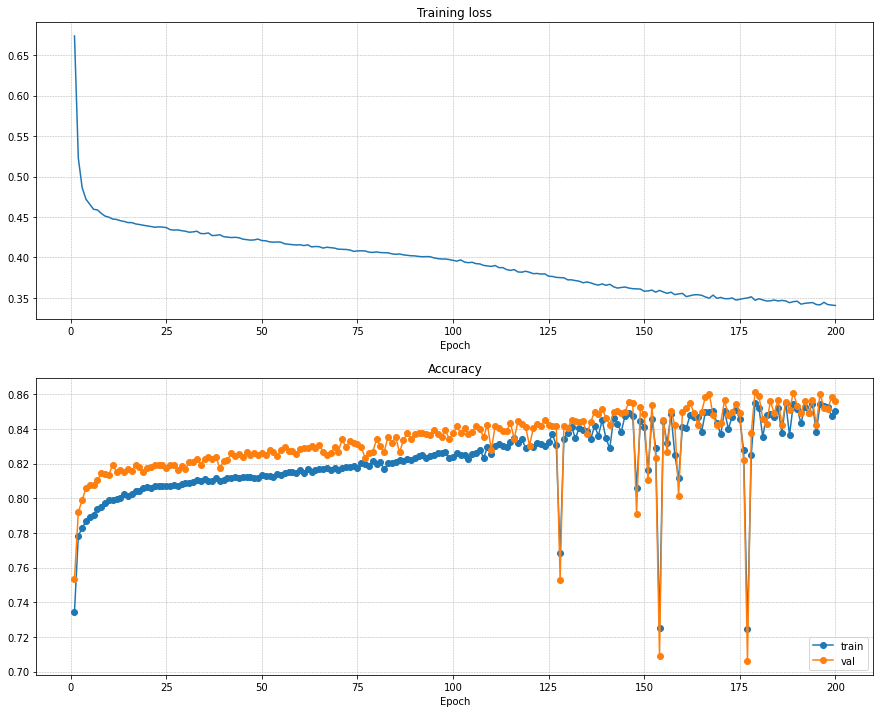

In [13]:
dim = range(1, len(hist_narrow["loss_train"])+1)

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(dim, hist_narrow["loss_train"])
plt.xlabel('Epoch')
plt.grid(linestyle='--', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(dim, hist_narrow["acc_train"], '-o', label='train')
plt.plot(dim, hist_narrow["acc_val"], '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# Widening the network - .88 accuracy
Add more channels in layer 1

In [15]:
model = Net(n_chans1=16).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, 
                                         shuffle=False)

hist = training_loop(
    n_epochs = 200,
    device=device,
    optimizer = optimizer,
    model = model,

    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 03:42:10.934067 Epoch 1, Loss train 0.568 Acc train 0.778 val 0.789
2022-01-31 03:42:12.680214 Epoch 2, Loss train 0.483 Acc train 0.789 val 0.801
2022-01-31 03:42:13.597367 Epoch 3, Loss train 0.456 Acc train 0.797 val 0.805
2022-01-31 03:42:14.508724 Epoch 4, Loss train 0.430 Acc train 0.811 val 0.818
2022-01-31 03:42:15.430711 Epoch 5, Loss train 0.406 Acc train 0.826 val 0.832
2022-01-31 03:42:16.349768 Epoch 6, Loss train 0.384 Acc train 0.831 val 0.836
2022-01-31 03:42:17.266662 Epoch 7, Loss train 0.368 Acc train 0.840 val 0.839
2022-01-31 03:42:18.199797 Epoch 8, Loss train 0.355 Acc train 0.844 val 0.843
2022-01-31 03:42:19.130496 Epoch 9, Loss train 0.347 Acc train 0.851 val 0.843
2022-01-31 03:42:20.058764 Epoch 10, Loss train 0.339 Acc train 0.853 val 0.846
2022-01-31 03:42:20.990961 Epoch 11, Loss train 0.333 Acc train 0.856 val 0.844
2022-01-31 03:42:21.915084 Epoch 12, Loss train 0.326 Acc train 0.861 val 0.850
2022-01-31 03:42:22.837532 Epoch 13, Loss train 0

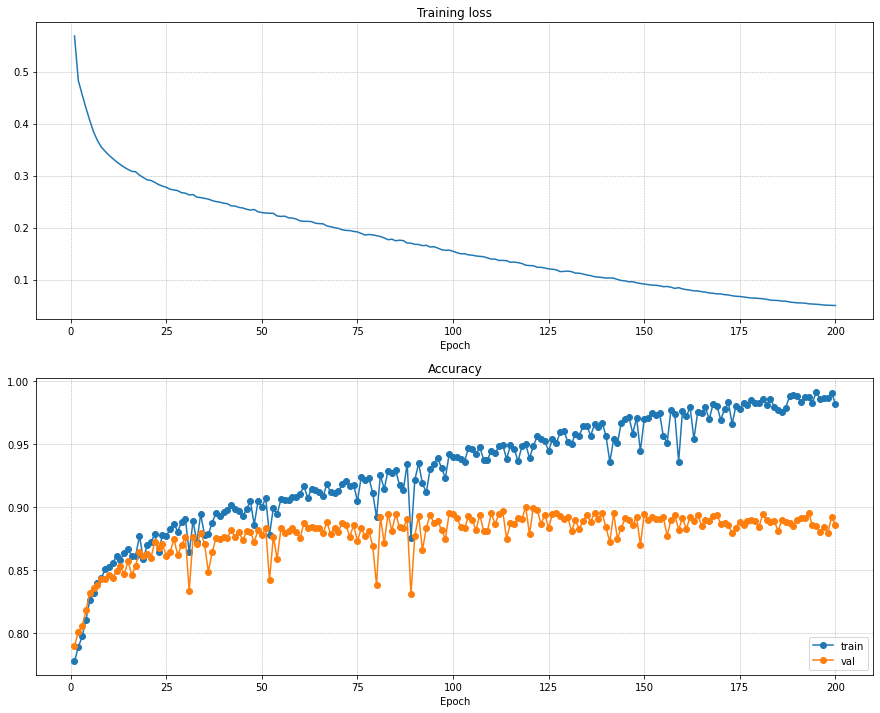

In [16]:
dim = range(1, len(hist["loss_train"])+1)

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(dim, hist["loss_train"])
plt.xlabel('Epoch')
plt.grid(linestyle='--', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(dim, hist["acc_train"], '-o', label='train')
plt.plot(dim, hist["acc_val"], '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# L2 weight decay - .88 accuracy
Weight decay can be used to reduce overfitting. 

In [17]:
model = Net().to(device=device)
optimizer_weight_decay = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2) # Add L2 weight decay
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, 
                                         shuffle=False)

hist_weight_decay = training_loop(
    n_epochs = 200,
    device=device,
    optimizer = optimizer_weight_decay,
    model = model,

    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 03:47:53.829912 Epoch 1, Loss train 0.578 Acc train 0.773 val 0.785
2022-01-31 03:47:54.769825 Epoch 2, Loss train 0.491 Acc train 0.789 val 0.790
2022-01-31 03:47:55.719503 Epoch 3, Loss train 0.470 Acc train 0.798 val 0.805
2022-01-31 03:47:56.653356 Epoch 4, Loss train 0.450 Acc train 0.806 val 0.818
2022-01-31 03:47:57.590582 Epoch 5, Loss train 0.430 Acc train 0.820 val 0.819
2022-01-31 03:47:58.518138 Epoch 6, Loss train 0.408 Acc train 0.831 val 0.831
2022-01-31 03:47:59.466682 Epoch 7, Loss train 0.385 Acc train 0.838 val 0.833
2022-01-31 03:48:00.383059 Epoch 8, Loss train 0.367 Acc train 0.841 val 0.837
2022-01-31 03:48:01.320033 Epoch 9, Loss train 0.353 Acc train 0.846 val 0.834
2022-01-31 03:48:02.242934 Epoch 10, Loss train 0.343 Acc train 0.852 val 0.840
2022-01-31 03:48:03.167500 Epoch 11, Loss train 0.335 Acc train 0.855 val 0.841
2022-01-31 03:48:04.102019 Epoch 12, Loss train 0.332 Acc train 0.855 val 0.850
2022-01-31 03:48:05.033794 Epoch 13, Loss train 0

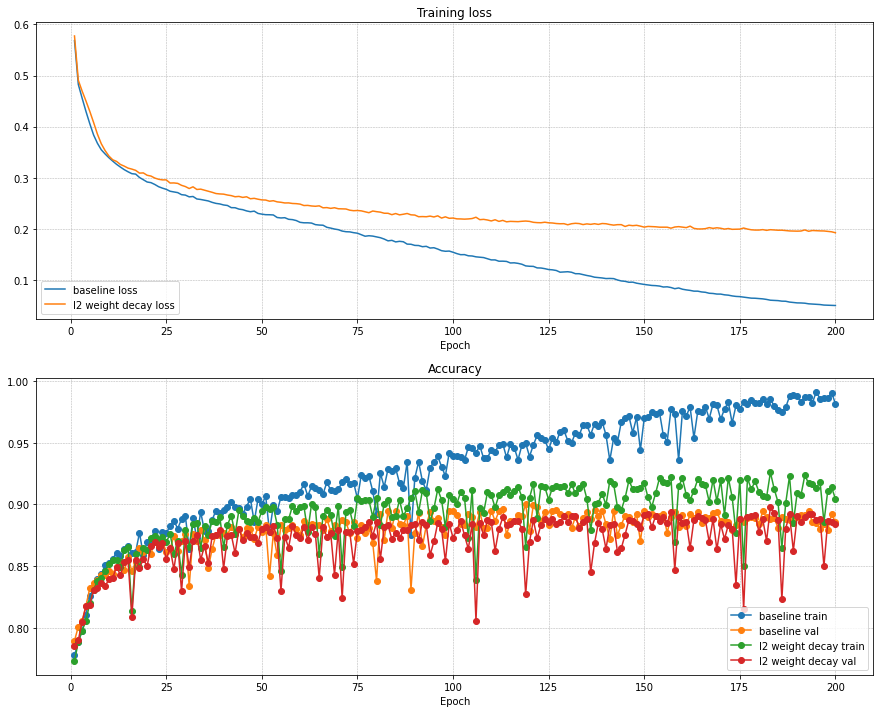

In [18]:
dim = range(1, len(hist["loss_train"])+1)

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(dim, hist["loss_train"], label='baseline loss')
plt.plot(dim, hist_weight_decay["loss_train"], label='l2 weight decay loss')
plt.legend(loc='lower left')
plt.xlabel('Epoch')
plt.grid(linestyle='--', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(dim, hist["acc_train"], '-o', label='baseline train')
plt.plot(dim, hist["acc_val"], '-o', label='baseline val')
plt.plot(dim, hist_weight_decay["acc_train"], '-o', label='l2 weight decay train')
plt.plot(dim, hist_weight_decay["acc_val"], '-o', label='l2 weight decay val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# Batch Normalization - 0.86 accuracy

In [31]:
class NetBatchNorm(nn.Module):
  def __init__(self, n_chans1=16):
    super().__init__()

    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1) # Batch normalization
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
    self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1//2) # Batch normalization
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)

    self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)
    self.act3 = nn.Tanh()

    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1_batchnorm(self.conv1(x))))
    out = self.pool2(self.act2(self.conv2_batchnorm(self.conv2(out))))
    out = out.view(-1, 8*8*(self.n_chans1//2)) # In place of nn.Flatten()
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [32]:
model_batch_norm = NetBatchNorm().to(device=device)
optimizer = optim.SGD(model_batch_norm.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, 
                                         shuffle=False)

loss_fn = nn.CrossEntropyLoss()

hist_batch_norm = training_loop(
    n_epochs = 200,
    device=device,
    optimizer = optimizer,
    model = model_batch_norm,

    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 04:06:25.352348 Epoch 1, Loss train 0.509 Acc train 0.802 val 0.812
2022-01-31 04:06:26.406651 Epoch 2, Loss train 0.401 Acc train 0.831 val 0.835
2022-01-31 04:06:27.454590 Epoch 3, Loss train 0.364 Acc train 0.842 val 0.830
2022-01-31 04:06:28.508152 Epoch 4, Loss train 0.347 Acc train 0.853 val 0.844
2022-01-31 04:06:29.556161 Epoch 5, Loss train 0.334 Acc train 0.851 val 0.846
2022-01-31 04:06:30.609305 Epoch 6, Loss train 0.328 Acc train 0.841 val 0.829
2022-01-31 04:06:31.657229 Epoch 7, Loss train 0.318 Acc train 0.862 val 0.858
2022-01-31 04:06:32.692085 Epoch 8, Loss train 0.311 Acc train 0.868 val 0.857
2022-01-31 04:06:33.736851 Epoch 9, Loss train 0.303 Acc train 0.875 val 0.860
2022-01-31 04:06:34.783261 Epoch 10, Loss train 0.300 Acc train 0.880 val 0.873
2022-01-31 04:06:35.847519 Epoch 11, Loss train 0.291 Acc train 0.880 val 0.870
2022-01-31 04:06:36.889293 Epoch 12, Loss train 0.283 Acc train 0.870 val 0.871
2022-01-31 04:06:37.928122 Epoch 13, Loss train 0

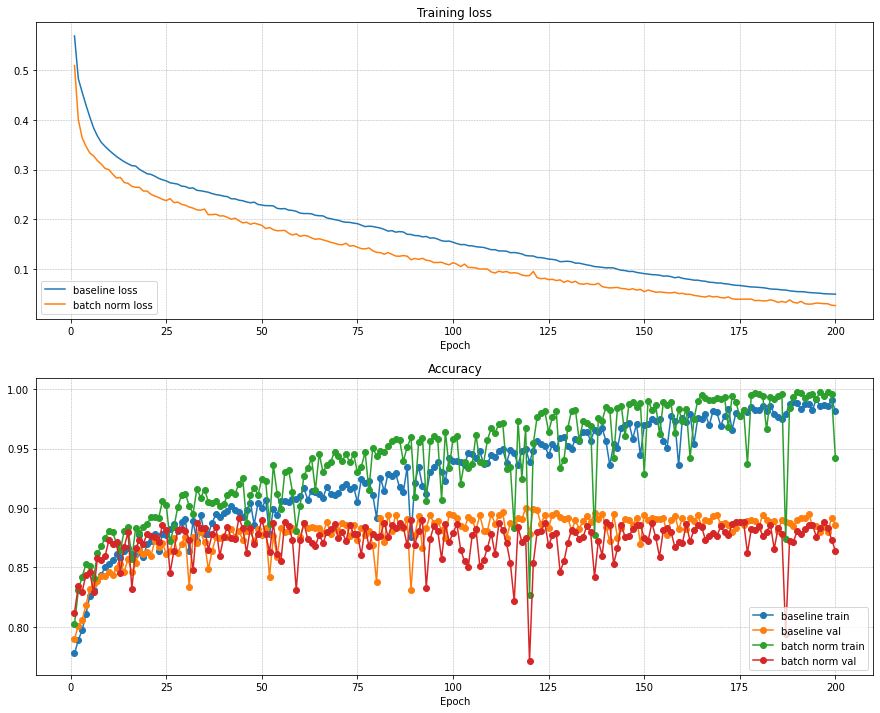

In [33]:
dim = range(1, len(hist["loss_train"])+1)

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(dim, hist["loss_train"], label='baseline loss')
plt.plot(dim, hist_batch_norm["loss_train"], label='batch norm loss')
plt.legend(loc='lower left')
plt.xlabel('Epoch')
plt.grid(linestyle='--', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(dim, hist["acc_train"], '-o', label='baseline train')
plt.plot(dim, hist["acc_val"], '-o', label='baseline val')
plt.plot(dim, hist_batch_norm["acc_train"], '-o', label='batch norm train')
plt.plot(dim, hist_batch_norm["acc_val"], '-o', label='batch norm val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# Dropout - .9 accuray

In [28]:
class NetDropout(nn.Module):
  def __init__(self, n_chans1=16, dropout_p=0.4):
    super().__init__()

    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv1_dropout = nn.Dropout2d(p=dropout_p) # Add dropout

    self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.conv2_dropout = nn.Dropout2d(p=dropout_p) # Add dropout

    self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)
    self.act3 = nn.Tanh()

    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.conv1_dropout(out)
    out = self.pool2(self.act2(self.conv2(out)))
    out = self.conv2_dropout(out)
    out = out.view(-1, 8*8*(self.n_chans1//2)) # In place of nn.Flatten()
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [29]:
model_dropout = NetDropout().to(device=device)
optimizer = optim.SGD(model_dropout.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, 
                                         shuffle=False)

hist_dropout = training_loop(
    n_epochs = 200,
    device=device,
    optimizer = optimizer,
    model = model_dropout,

    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 04:01:42.144238 Epoch 1, Loss train 0.606 Acc train 0.763 val 0.764
2022-01-31 04:01:43.142480 Epoch 2, Loss train 0.527 Acc train 0.789 val 0.800
2022-01-31 04:01:44.110688 Epoch 3, Loss train 0.503 Acc train 0.797 val 0.802
2022-01-31 04:01:45.132383 Epoch 4, Loss train 0.475 Acc train 0.810 val 0.814
2022-01-31 04:01:46.117207 Epoch 5, Loss train 0.460 Acc train 0.816 val 0.822
2022-01-31 04:01:47.076002 Epoch 6, Loss train 0.441 Acc train 0.823 val 0.822
2022-01-31 04:01:48.058942 Epoch 7, Loss train 0.427 Acc train 0.827 val 0.823
2022-01-31 04:01:49.344228 Epoch 8, Loss train 0.418 Acc train 0.832 val 0.830
2022-01-31 04:01:50.599539 Epoch 9, Loss train 0.410 Acc train 0.840 val 0.831
2022-01-31 04:01:51.870004 Epoch 10, Loss train 0.404 Acc train 0.842 val 0.832
2022-01-31 04:01:52.857153 Epoch 11, Loss train 0.397 Acc train 0.841 val 0.835
2022-01-31 04:01:53.848588 Epoch 12, Loss train 0.395 Acc train 0.847 val 0.840
2022-01-31 04:01:54.833720 Epoch 13, Loss train 0

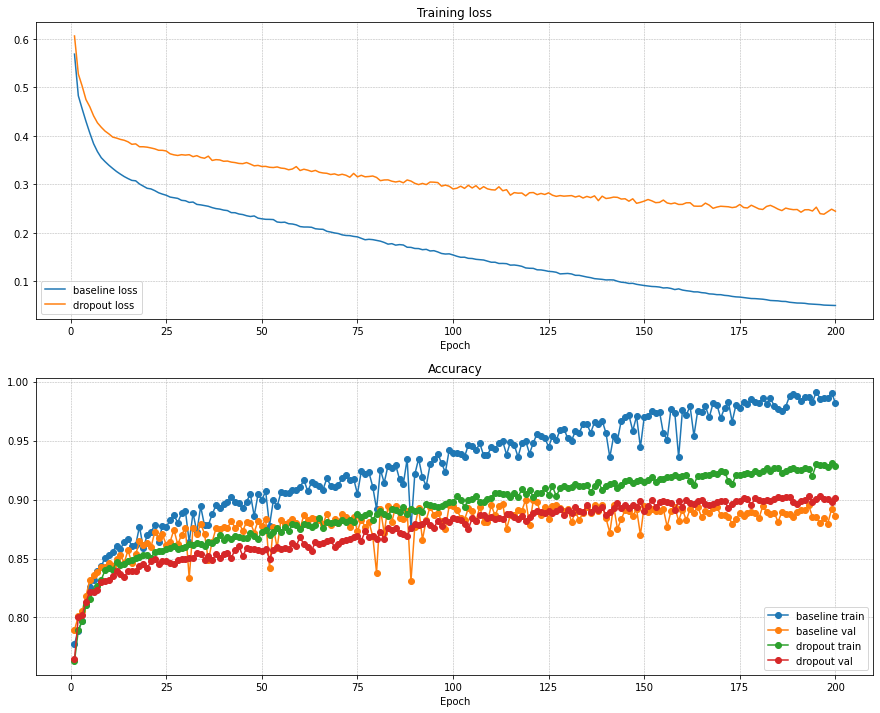

In [30]:
dim = range(1, len(hist["loss_train"])+1)

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(dim, hist["loss_train"], label='baseline loss')
plt.plot(dim, hist_dropout["loss_train"], label='dropout loss')
plt.legend(loc='lower left')
plt.xlabel('Epoch')
plt.grid(linestyle='--', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(dim, hist["acc_train"], '-o', label='baseline train')
plt.plot(dim, hist["acc_val"], '-o', label='baseline val')
plt.plot(dim, hist_dropout["acc_train"], '-o', label='dropout train')
plt.plot(dim, hist_dropout["acc_val"], '-o', label='dropout val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# Wider batch size - .87 accuracy

In [35]:
model = Net(n_chans1=16).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=512,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=512, 
                                         shuffle=False)

hist_wide_batch = training_loop(
    n_epochs = 200,
    device=device,
    optimizer = optimizer,
    model = model,

    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 04:13:54.355762 Epoch 1, Loss train 0.693 Acc train 0.639 val 0.647
2022-01-31 04:13:54.891003 Epoch 2, Loss train 0.658 Acc train 0.657 val 0.657
2022-01-31 04:13:55.421227 Epoch 3, Loss train 0.634 Acc train 0.679 val 0.683
2022-01-31 04:13:55.952432 Epoch 4, Loss train 0.609 Acc train 0.705 val 0.715
2022-01-31 04:13:56.484021 Epoch 5, Loss train 0.582 Acc train 0.732 val 0.735
2022-01-31 04:13:57.011678 Epoch 6, Loss train 0.554 Acc train 0.753 val 0.750
2022-01-31 04:13:57.542711 Epoch 7, Loss train 0.530 Acc train 0.766 val 0.768
2022-01-31 04:13:58.069865 Epoch 8, Loss train 0.514 Acc train 0.774 val 0.781
2022-01-31 04:13:58.598609 Epoch 9, Loss train 0.501 Acc train 0.780 val 0.783
2022-01-31 04:13:59.125504 Epoch 10, Loss train 0.493 Acc train 0.781 val 0.786
2022-01-31 04:13:59.654347 Epoch 11, Loss train 0.487 Acc train 0.788 val 0.790
2022-01-31 04:14:00.179495 Epoch 12, Loss train 0.483 Acc train 0.791 val 0.796
2022-01-31 04:14:00.705453 Epoch 13, Loss train 0

# Deeper network - .88 accuracy

In [48]:
class NetDeeper(nn.Module):
  def __init__(self, n_chans1=16, dropout_p=0.4):
    super().__init__()

    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1) # Out: 32x32x(n_chans1)
    self.act1 = nn.Tanh()
    self.dropout1 = nn.Dropout2d(p=dropout_p)

    self.conv1a = nn.Conv2d(n_chans1, n_chans1, kernel_size=3, padding=1) # Out: 32x32x(n_chans1)
    self.act1a = nn.Tanh()
    self.pool1a = nn.MaxPool2d(2) # Out: 16x16x(n_chans1)
    self.dropout1a = nn.Dropout2d(p=dropout_p)

    self.conv2a = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1) # Out: 16x16x(n_chans1//2)
    self.act2a = nn.Tanh()
    self.pool2a = nn.MaxPool2d(2) # Out: 8x8x(n_chans1//2)
    self.dropout2a = nn.Dropout2d(p=dropout_p)

    self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)
    self.act3 = nn.Tanh()

    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.dropout1(self.act1(self.conv1(x)))
    out = self.dropout1a(self.pool1a(self.act1a(self.conv1a(out))))
    out = self.dropout2a(self.pool2a(self.act2a(self.conv2a(out))))
    out = out.view(-1, 8*8*(self.n_chans1//2)) # In place of nn.Flatten()
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [49]:
model_deeper = NetDeeper().to(device=device)
optimizer = optim.SGD(model_deeper.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, 
                                         shuffle=False)

hist_deeper = training_loop(
    n_epochs = 200,
    device=device,
    optimizer = optimizer,
    model = model_deeper,

    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 04:36:50.526536 Epoch 1, Loss train 0.631 Acc train 0.757 val 0.764
2022-01-31 04:36:52.132741 Epoch 2, Loss train 0.536 Acc train 0.773 val 0.780
2022-01-31 04:36:53.730806 Epoch 3, Loss train 0.509 Acc train 0.779 val 0.785
2022-01-31 04:36:55.344854 Epoch 4, Loss train 0.495 Acc train 0.781 val 0.788
2022-01-31 04:36:56.945530 Epoch 5, Loss train 0.485 Acc train 0.786 val 0.797
2022-01-31 04:36:58.541157 Epoch 6, Loss train 0.481 Acc train 0.787 val 0.800
2022-01-31 04:37:00.135501 Epoch 7, Loss train 0.474 Acc train 0.789 val 0.802
2022-01-31 04:37:01.735627 Epoch 8, Loss train 0.470 Acc train 0.794 val 0.805
2022-01-31 04:37:03.332683 Epoch 9, Loss train 0.466 Acc train 0.797 val 0.809
2022-01-31 04:37:04.917986 Epoch 10, Loss train 0.461 Acc train 0.803 val 0.809
2022-01-31 04:37:06.520656 Epoch 11, Loss train 0.459 Acc train 0.806 val 0.814
2022-01-31 04:37:08.116467 Epoch 12, Loss train 0.452 Acc train 0.808 val 0.815
2022-01-31 04:37:09.700667 Epoch 13, Loss train 0

# ReLU activation, Adam optimizer - 0.86 accuracy 

In [50]:
class NetReLU(nn.Module):
  def __init__(self, n_chans1=16, dropout_p=0.4):
    super().__init__()

    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)
    self.conv1_dropout = nn.Dropout2d(p=dropout_p) # Add dropout

    self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2)
    self.conv2_dropout = nn.Dropout2d(p=dropout_p) # Add dropout

    self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)
    self.act3 = nn.ReLU()

    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.conv1_dropout(out)
    out = self.pool2(self.act2(self.conv2(out)))
    out = self.conv2_dropout(out)
    out = out.view(-1, 8*8*(self.n_chans1//2)) # In place of nn.Flatten()
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [52]:
model_relu = NetReLU().to(device=device)
optimizer = optim.Adam(model_relu.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, 
                                         shuffle=False)

hist_dropout = training_loop(
    n_epochs = 200,
    device=device,
    optimizer = optimizer,
    model = model_relu,

    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 04:42:51.259946 Epoch 1, Loss train 0.580 Acc train 0.780 val 0.781
2022-01-31 04:42:52.284694 Epoch 2, Loss train 0.501 Acc train 0.828 val 0.827
2022-01-31 04:42:53.342532 Epoch 3, Loss train 0.477 Acc train 0.823 val 0.822
2022-01-31 04:42:54.372160 Epoch 4, Loss train 0.442 Acc train 0.848 val 0.850
2022-01-31 04:42:55.391477 Epoch 5, Loss train 0.433 Acc train 0.796 val 0.798
2022-01-31 04:42:56.404832 Epoch 6, Loss train 0.420 Acc train 0.831 val 0.825
2022-01-31 04:42:57.734437 Epoch 7, Loss train 0.413 Acc train 0.855 val 0.849
2022-01-31 04:42:58.747923 Epoch 8, Loss train 0.404 Acc train 0.851 val 0.851
2022-01-31 04:42:59.767384 Epoch 9, Loss train 0.414 Acc train 0.860 val 0.860
2022-01-31 04:43:00.788630 Epoch 10, Loss train 0.396 Acc train 0.842 val 0.833
2022-01-31 04:43:01.801574 Epoch 11, Loss train 0.384 Acc train 0.868 val 0.856
2022-01-31 04:43:02.813516 Epoch 12, Loss train 0.390 Acc train 0.841 val 0.840
2022-01-31 04:43:03.843729 Epoch 13, Loss train 0